# Introduction / Setup

This notebook shows how to use LangChain's [`LLMGraphTransformer`](https://python.langchain.com/docs/use_cases/graph/constructing/#llm-graph-transformer) to extract knowledge triples and store them in [DataStax AstraDB](https://www.datastax.com/products/datastax-astra).

In [ ]:
# (Optional) When developing locally, this reloads the module code when changes are made,
# making it easier to iterate.
%load_ext autoreload
%autoreload 2

In [ ]:
# (Required in Colab) Install the knowledge graph library from the repository.
# This will also install the dependencies.
%pip install https://github.com/datastax-labs/knowledge-graphs-langchain/archive/main.zip

## Environment
Pick one of the following.
1. If you're just running the notebook, it's probably best to run the cell using `getpass` to set the necessary
   environment variables.
1. If you're developing, it's likely easiest to create a `.env` file and store the necessary credentials.

In [ ]:
# (Option 1) - Set the environment variables from getpass.
import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter OpenAI API Key: ")
os.environ["ASTRA_DB_DATABASE_ID"] = input("Enter Astra DB Database ID: ")
os.environ["ASTRA_DB_APPLICATION_TOKEN"] = getpass.getpass("Enter Astra DB Application Token: ")

keyspace = input("Enter Astra DB Keyspace (Empty for default): ")
if keyspace:
    os.environ["ASTRA_DB_KEYSPACE"] = keyspace
else:
    os.environ.pop("ASTRA_DB_KEYSPACE", None)

In [1]:
# (Option 2) - Load the `.env` file.
# See `env.template` for an example of what you should have there.
%pip install python-dotenv
import dotenv
dotenv.load_dotenv()


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


True

## Initialize Astra DB / Cassandra

In [2]:
# Initialize cassandra connection from environment variables).
import cassio
cassio.init(auto=True)

## Create Graph Store

In [3]:
# Create graph store.
from knowledge_graph.cassandra_graph_store import CassandraGraphStore
graph_store = CassandraGraphStore()

# Extracting Knowledge Graph

In [4]:
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_openai import ChatOpenAI

# Prompt used by LLMGraphTransformer is tuned for Gpt4.
llm = ChatOpenAI(temperature=0, model_name="gpt-4")

llm_transformer = LLMGraphTransformer(llm=llm)

In [5]:
from langchain_core.documents import Document

text = """
Marie Curie, was a Polish and naturalised-French physicist and chemist who conducted pioneering research on radioactivity.
She was the first woman to win a Nobel Prize, the first person to win a Nobel Prize twice, and the only person to win a Nobel Prize in two scientific fields.
Her husband, Pierre Curie, was a co-winner of her first Nobel Prize, making them the first-ever married couple to win the Nobel Prize and launching the Curie family legacy of five Nobel Prizes.
She was, in 1906, the first woman to become a professor at the University of Paris.
"""
documents = [Document(page_content=text)]
graph_documents = llm_transformer.convert_to_graph_documents(documents)
print(f"Nodes:{graph_documents[0].nodes}")
print(f"Relationships:{graph_documents[0].relationships}")

Nodes:[Node(id='Marie Curie', type='Person'), Node(id='Pierre Curie', type='Person'), Node(id='Nobel Prize', type='Award'), Node(id='University Of Paris', type='Organization'), Node(id='Polish', type='Nationality'), Node(id='French', type='Nationality'), Node(id='Physicist', type='Profession'), Node(id='Chemist', type='Profession'), Node(id='Radioactivity', type='Scientific field'), Node(id='Professor', type='Profession')]
Relationships:[Relationship(source=Node(id='Marie Curie', type='Person'), target=Node(id='Polish', type='Nationality'), type='HAS_NATIONALITY'), Relationship(source=Node(id='Marie Curie', type='Person'), target=Node(id='French', type='Nationality'), type='HAS_NATIONALITY'), Relationship(source=Node(id='Marie Curie', type='Person'), target=Node(id='Physicist', type='Profession'), type='HAS_PROFESSION'), Relationship(source=Node(id='Marie Curie', type='Person'), target=Node(id='Chemist', type='Profession'), type='HAS_PROFESSION'), Relationship(source=Node(id='Marie Cur

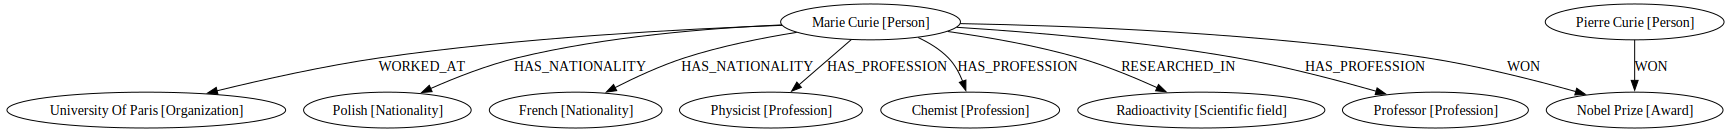

In [6]:
# Render the extracted graph to GraphViz.
from knowledge_graph.render import render_graph_documents
render_graph_documents(graph_documents)

In [7]:
# Save the extracted graph documents to the AstraDB / Cassandra Graph Store.
graph_store.add_graph_documents(graph_documents)

### Optional: Predefine entities / relationships

The below shows how to configure the `LLMGraphTransformer` with specific kinds of nodes and relationships it is allowed to extract.
This is useful for constraining what will be extracted.

```python
llm_transformer_filtered = LLMGraphTransformer(
    llm=llm,
    allowed_nodes=["Person", "Country", "Organization"],
    allowed_relationships=["NATIONALITY", "LOCATED_IN", "WORKED_AT", "SPOUSE"],
)
graph_documents_filtered = llm_transformer_filtered.convert_to_graph_documents(
    documents
)
print(f"Nodes:{graph_documents_filtered[0].nodes}")
print(f"Relationships:{graph_documents_filtered[0].relationships}")
```

# Querying

We can query the `GraphStore` directly. The `as_runnable` method takes some configuration for how to extract the subgraph and returns a LangChain `Runnable` which can be invoked on a node or sequence of nodes to traverse from those starting points.

In [8]:
from knowledge_graph.traverse import Node

graph_store.as_runnable(steps=2).invoke(Node("Marie Curie", "Person"))

{Marie Curie(Person) -> Chemist(Profession): HAS_PROFESSION,
 Marie Curie(Person) -> French(Nationality): HAS_NATIONALITY,
 Marie Curie(Person) -> Nobel Prize(Award): WON,
 Marie Curie(Person) -> Physicist(Profession): HAS_PROFESSION,
 Marie Curie(Person) -> Pierre Curie(Person): MARRIED_TO,
 Marie Curie(Person) -> Polish(Nationality): HAS_NATIONALITY,
 Marie Curie(Person) -> Professor(Profession): HAS_PROFESSION,
 Marie Curie(Person) -> Radioactivity(Scientific concept): RESEARCHED,
 Marie Curie(Person) -> Radioactivity(Scientific field): RESEARCHED_IN,
 Marie Curie(Person) -> University Of Paris(Organization): WORKED_AT,
 Pierre Curie(Person) -> Nobel Prize(Award): WON}

For getting started, the library also provides a `Runnable` for extracting the starting entities from a question.

In [9]:
# Example showing extracted entities (nodes)
from knowledge_graph import extract_entities
extract_entities(llm).invoke({ "question": "Who is Marie Curie?"})

[Marie Curie(Person)]

## Query Chain

We'll create a chain which does the following:

1. Use the entity extraction `Runnable` from the library in order to determine the starting points.
2. Retrieve the sub-knowledge graphs starting from those nodes.
3. Create a context containing those knowledge triples.
4. Apply the LLM to answer the question given the context. 

In [10]:
from operator import itemgetter
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from knowledge_graph import extract_entities
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model_name = "gpt-4")

def _combine_relations(relations):
    return "\n".join(map(repr, relations))

ANSWER_PROMPT = (
    "The original question is given below."
    "This question has been used to retrieve information from a knowledge graph."
    "The matching triples are shown below."
    "Use the information in the triples to answer the original question.\n\n"
    "Original Question: {question}\n\n"
    "Knowledge Graph Triples:\n{context}\n\n"
    "Response:"
)

chain = (
    { "question": RunnablePassthrough() }
    | RunnablePassthrough.assign(entities = extract_entities(llm))
    | RunnablePassthrough.assign(triples = itemgetter("entities") | graph_store.as_runnable())
    | RunnablePassthrough.assign(context = itemgetter("triples") | RunnableLambda(_combine_relations))
    | ChatPromptTemplate.from_messages([ANSWER_PROMPT])
    | llm
)

## Example
And finally, we can run the chain end to end to answer a question using the retrieved knowledge.

In [12]:
chain.invoke("Who is Marie Curie?")

AIMessage(content='Marie Curie is a Polish and French chemist, professor, and physicist who researched radioactivity and worked at the University of Paris. She was married to Pierre Curie and both of them have won the Nobel Prize.', response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 246, 'total_tokens': 291}, 'model_name': 'gpt-4', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-85a75d94-705a-4c49-9bcf-f16ae77b1c7d-0')